In [1]:
from google.colab import drive
import os
drive.mount('/gdrive')
os.getcwd()
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Mounted at /gdrive


'/content'

In [3]:
root = "/gdrive/My Drive/CS470/cs470_music_generator"
root_data = '/gdrive/My Drive/CS470/data'
root_midi = '/gdrive/My Drive/CS470/data/midi'
os.chdir(root)
os.getcwd()

'/gdrive/My Drive/CS470/cs470_music_generator'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
import pickle
import random

In [5]:
def word_encode(words_arr, word):
    return (words_arr == word).astype(np.float).reshape(1,-1)

def word_mapping(words_arr, word):
    return words_arr[word]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, embed):
        super(Model,self).__init__()

        self.embed = embed
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.cell = nn.GRU(input_size=hidden_size if embed else input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
    def forward(self,input):
        batch_size = input.size()[0]
        hidden = self._init_hidden(batch_size)
        if self.embed:
            x_ = self.encoder(input)
        else:
            x_ = input
        output, hidden = self.cell(x_, hidden)
        fc_output = self.fc(output.view(-1, hidden_size))
        return fc_output
    
    def forward2(self, input, hidden):
        if self.embed:
            x_ = self.encoder(input)
        else:
            x_ = input
        output,hidden = self.cell(x_,hidden)
        fc_output = self.fc(output.view(-1, hidden_size))
        return fc_output, hidden
    
    def _init_hidden(self,batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden

In [8]:
lines = list(map(lambda x: x.strip(), open("data/cleaned_lyrics.txt").readlines()))
lines = '\n'.join(lines)
words_arr = np.array(list(set(re.findall(r'\S+|\n', lines))))
n_words = len(words_arr)

In [9]:
input_size = n_words
hidden_size = 256 
num_layers = 1
output_size = n_words

lyrics_model = Model(input_size, hidden_size, num_layers, output_size, False).to(device)

lyrics_model

Model(
  (cell): GRU(4405, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=4405, bias=True)
  (encoder): Embedding(4405, 256)
)

In [10]:
!git clone https://github.com/bearpelican/musicautobot.git
os.chdir('musicautobot')
os.getcwd()

fatal: destination path 'musicautobot' already exists and is not an empty directory.


'/gdrive/My Drive/CS470/cs470_music_generator/musicautobot'

In [11]:
!apt-get update
!apt install musescore fluidsynth
!pip install torch fastai music21 pebble fluidsynth midi2audio

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/mai

In [12]:
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils import midifile

os.chdir('..')
os.getcwd()

'/gdrive/My Drive/CS470/cs470_music_generator'

In [13]:
with open("data/dataset_np.pkl", "rb") as fd:
  music_data = pickle.load(fd)

with open("data/music_vocab.pkl", "rb") as fd:
  music_vocab = pickle.load(fd)
  
train_data = list(map(lambda x: x["np"], music_data))
X_train = np.concatenate(train_data, axis=0)
music_arr = np.array(list(set(X_train)))
n_characters = len(music_arr)

In [14]:
def plot_music(x):
  npenc = idxenc2npenc(x, music_vocab)
  item = MusicItem.from_npenc(npenc, music_vocab)
  item.show()
  return item

In [15]:
embed = False
transformer = False

input_size = n_characters
hidden_size = 64 if embed else 256 
num_layers = 1 # one-layer rnn
output_size = n_characters
batch_size = 8
input_size

if transformer:
  music_model = nn.Transformer(d_model=n_characters, nhead=13, num_encoder_layers=1, num_decoder_layers=1).to(device)
else:
  music_model = Model(input_size, hidden_size, num_layers, output_size, embed).to(device)

music_model

Model(
  (cell): GRU(169, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=169, bias=True)
  (encoder): Embedding(169, 256)
)

In [16]:
def generate(model, max_n=None, max_tokens=300, temperature=0.7, top_k=32, arr=None, embed=None, lyrics=False):
    text = []
    letter = random.randint(0, max_n)  
    if embed:
      letter = [letter]
    if lyrics:
      letter = [word_mapping(arr, letter)]
    if type(letter) == list:
      text.append(letter[0])
    else:
      text.append(word_mapping(arr, letter) if lyrics else letter)
    hidden = model._init_hidden(1)
    with torch.no_grad():
        for i in range(max_tokens):
          tmp = word_encode(arr, letter)
          if embed:
            letter, hidden = model.forward2(torch.LongTensor(np.argmax(tmp, axis=1)).unsqueeze(0).to(device), hidden)
          else:
            letter, hidden = model.forward2(torch.FloatTensor(tmp).unsqueeze(0).to(device), hidden)
          if (i+1)%2 == 0:
              letter = arr[torch.multinomial(F.softmax(letter.view(1,-1)),1)]
          else:
              letter = arr[letter.view(1,-1).argmax(1)]
          text.append(letter)
    if embed:
      tmp = [i if type(i) != list else i[0] for i in text]
      text = tmp
    return text

In [19]:
music_model = torch.load("models/model_music1.pt")
lyrics_model = torch.load("models/model_lyrics1.pt")

In [21]:
with open("data/words_arr.pkl", "br") as fd:
  words_arr = pickle.load(fd)

with open("data/music_arr.pkl", "br") as fd:
  music_arr = pickle.load(fd)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


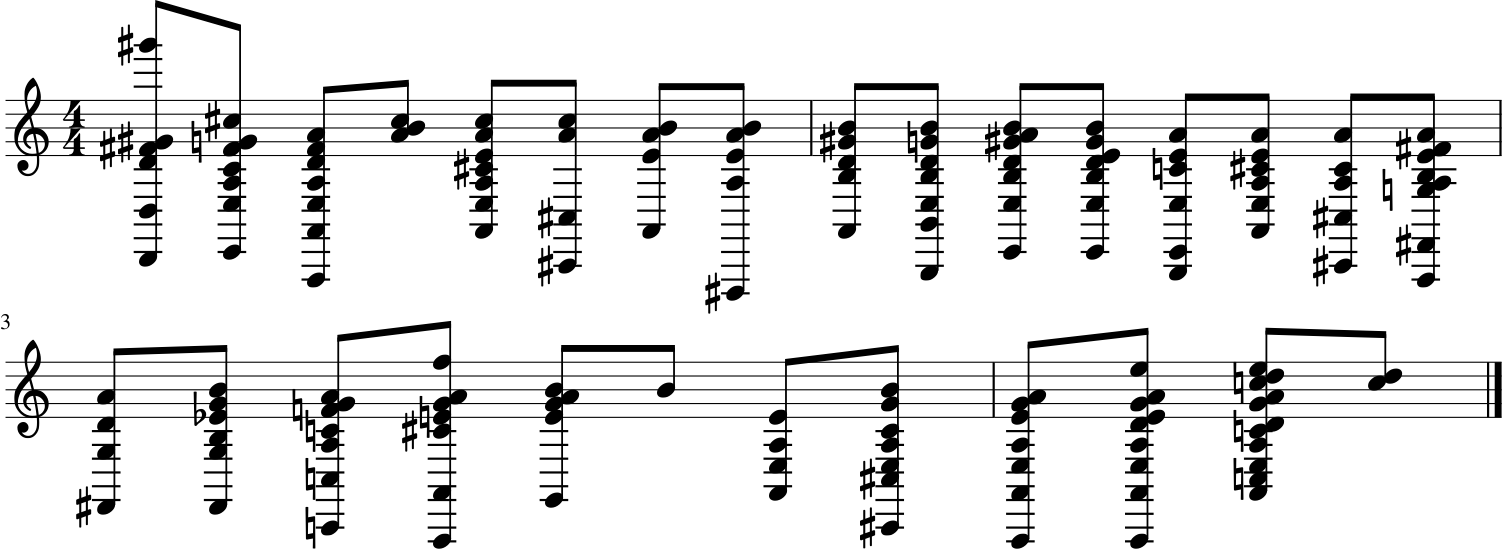

creme tangerine and montelimar 
 a ginger sling with a pineapple heart 
 coffee dessert yes you know going good news 
 but youll have to have them all pulled out 
 after the savoy truffle 
 you gave me no past seeking past 
 dont let me understand 
 dont let me down dont let me down 
 dont let me down dont let me too 
 ooh im a feeling 
 let you down 
 oh oh oh 
 oh oh oh oh 
 oh yeah oh yeah 
 oh yeah oh yeah 
 yeah yeah ive got a feeling yeah 
 oh oh youve been good to me 
 ah da da ah 
 good been a long time 
 im waiting here you you 
 youll never know how much you like me 
 you may be a lover but you aint no dancer 
 look out 
 boys 
 dont you know my number 
 prr prr you know my name 
 you know my number 
 prr prr your number were on my number 
 i know my number 
 right my number 
 prr prr prr my number my number 
 prr my number


In [23]:
lyrics_length = 500

output = generate(music_model, max_n=n_characters, max_tokens=lyrics_length, arr=music_arr, embed=embed)
item = plot_music(np.array(output))

output = generate(lyrics_model, max_n=n_words, max_tokens=200, arr=words_arr, embed=False, lyrics=True)
print(' '.join(output))

In [ ]:
item.stream.write('midi', fp='music/complete.midi')